In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [2]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [3]:
df = data_main.copy()

In [4]:
# -----------------------------
# Step 1: Load & preprocess OHLC data
# -----------------------------
# df = pd.read_csv("ohlc.csv")  # Your OHLC dataset (must contain Open, High, Low, Close)

# Normalize OHLC
scaler = MinMaxScaler()
ohlc = scaler.fit_transform(df[["Open", "High", "Low", "Close"]])

# Create time series sequences
def create_sequences(data, window_size=10):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 10
sequences = create_sequences(ohlc, window_size)  # Shape: (num_samples, 10, 4)

# -----------------------------
# Step 2: Masking function
# -----------------------------
def mask_time_series(data, mask_ratio=0.15):
    mask = np.random.rand(*data.shape) < mask_ratio
    masked = data.copy()
    masked[mask] = 0  # Masked with 0s (can also use noise)
    return masked, mask

masked_sequences, mask = mask_time_series(sequences)

# -----------------------------
# Step 3: Transformer Encoder Block
# -----------------------------
def transformer_encoder(inputs, num_heads=4, dff=128, dropout_rate=0.1):
    # Multi-head attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)

    # Feedforward
    ffn_output = Dense(dff, activation="relu")(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    return LayerNormalization()(ffn_output)

# -----------------------------
# Step 4: Transformer Autoencoder
# -----------------------------
input_layer = Input(shape=(window_size, 4))
x = transformer_encoder(input_layer, num_heads=4)
x = transformer_encoder(x, num_heads=4)
output_layer = Dense(4)(x)  # Predict all 4 OHLC values

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="adam", loss="mse")
model.summary()

# -----------------------------
# Step 5: Train
# -----------------------------
model.fit(masked_sequences, sequences, epochs=20, batch_size=32)

# -----------------------------
# Step 6: Extract latent features
# -----------------------------
encoder = Model(inputs=input_layer, outputs=x)  # Use the second transformer's output as features
features = encoder.predict(sequences)  # Shape: (n_samples, 10, 4)

# Optional: Pool features (e.g., mean over time steps)
pooled_features = np.mean(features, axis=1)  # Shape: (n_samples, 4)

# -----------------------------
# Step 7: Cluster to get Buy/Sell/Hold
# -----------------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pooled_features)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 4)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 10, 4)                308       ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 10, 4)                0         ['multi_head_attention[0][0]']
                                                                                                  
 add (Add)                   (None, 10, 4)                0         ['input_1[0][0]',         

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: Columns must be same length as key

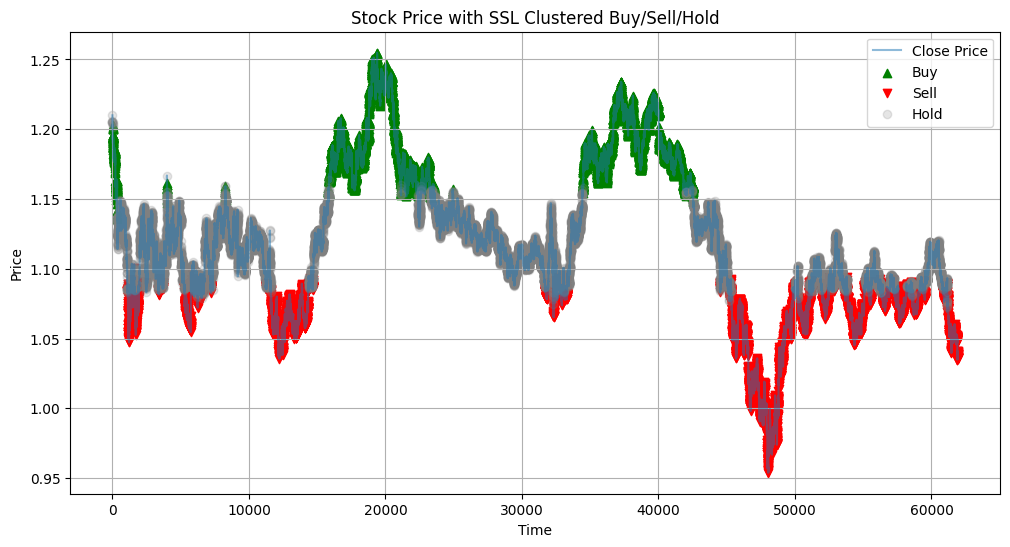

In [5]:
# Visualize clustering on price
df["Signal"] = "Hold"  # default
df.loc[window_size:, "Signal"] = pd.Series(clusters).map({0: "Buy", 1: "Sell", 2: "Hold"}).values


# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["Close"], label="Close Price", alpha=0.5)

buy_idx = df.index[df["Signal"] == "Buy"]
sell_idx = df.index[df["Signal"] == "Sell"]
hold_idx = df.index[df["Signal"] == "Hold"]

plt.scatter(buy_idx, df.loc[buy_idx, "Close"], color='green', label="Buy", marker="^")
plt.scatter(sell_idx, df.loc[sell_idx, "Close"], color='red', label="Sell", marker="v")
plt.scatter(hold_idx, df.loc[hold_idx, "Close"], color='gray', label="Hold", alpha=0.2)

plt.legend()
plt.title("Stock Price with SSL Clustered Buy/Sell/Hold")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()
